In [1]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt

orders         = pd.read_csv('Dataset/orders.csv')
prior_products = pd.read_csv('Dataset/order_products__prior.csv')
products       = pd.read_csv('Dataset/products.csv')
aisles         = pd.read_csv('Dataset/aisles.csv')

print("Orders:", orders.shape)
print("Prior items:", prior_products.shape)
print("Products:", products.shape)
orders.head()


Orders: (3421083, 7)
Prior items: (32434489, 4)
Products: (49688, 4)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [2]:
orders = orders[orders.eval_set == 'prior'].copy()
prior_products = prior_products.dropna(subset=['product_id'])
top_prods = prior_products['product_id'].value_counts().nlargest(1500).index
prior_products = prior_products[prior_products.product_id.isin(top_prods)]
print("Filtered prior_products:", prior_products.shape)


Filtered prior_products: (19776345, 4)


In [3]:
prior_items_aisle = (
    prior_products
      .merge(products[['product_id','aisle_id']], on='product_id', how='left')
      .merge(aisles, on='aisle_id', how='left')
)
prior_items_aisle.head()


,order_id,product_id,add_to_cart_order,reordered,aisle_id,aisle
0,2,33120,1,1,86,eggs
1,2,28985,2,1,83,fresh vegetables
2,2,9327,3,0,104,spices seasonings
3,2,17794,6,1,83,fresh vegetables
4,3,33754,1,1,120,yogurt


In [4]:
basket_aisle = (
    prior_items_aisle
      .groupby(['order_id','aisle'])['product_id']
      .count()
      .unstack(fill_value=0)
      .astype(bool)
)
print("Aisle-basket shape:", basket_aisle.shape)
basket_aisle.head()


Aisle-basket shape: (3034651, 99)


aisle,asian foods,baby accessories,baby food formula,baking ingredients,beers coolers,bread,breakfast bakery,bulk dried fruits vegetables,bulk grains rice dried goods,buns rolls,...,spirits,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,water seltzer sparkling water,white wines,yogurt
order_id,,,,,,,,,,,,,,,,,,,,,
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [5]:
sampled = basket_aisle.sample(n=100_000, random_state=42)
print("Sampled basket shape:", sampled.shape)


Sampled basket shape: (100000, 99)


In [6]:
freq_aisles = apriori(sampled, min_support=0.01, use_colnames=True)
aisle_rules = association_rules(freq_aisles, metric="confidence", min_threshold=0.3)
top_10_aisle = aisle_rules.nlargest(10, 'lift')[[
    'antecedents','consequents','support','confidence','lift'
]]
top_10_aisle


,antecedents,consequents,support,confidence,lift
1855,"(packaged vegetables fruits, packaged cheese, ...","(fresh fruits, yogurt, fresh vegetables)",0.01065,0.337239,3.714492
1853,"(yogurt, packaged vegetables fruits, packaged ...","(fresh fruits, fresh vegetables, milk)",0.01065,0.340473,3.645323
1845,"(fresh fruits, yogurt, packaged cheese, fresh ...","(packaged vegetables fruits, milk)",0.01065,0.337452,3.626182
1847,"(fresh fruits, packaged cheese, fresh vegetabl...","(yogurt, packaged vegetables fruits)",0.01065,0.330028,3.556335
1846,"(fresh fruits, packaged vegetables fruits, pac...","(yogurt, fresh vegetables)",0.01065,0.383231,3.490585
1849,"(yogurt, packaged vegetables fruits, fresh veg...","(fresh fruits, packaged cheese)",0.01065,0.413592,3.449477
1833,"(yogurt, packaged cheese, fresh vegetables)","(packaged vegetables fruits, milk)",0.01129,0.314310,3.377494
1843,"(fresh fruits, yogurt, packaged vegetables fru...","(fresh vegetables, milk)",0.01065,0.381857,3.305838
1842,"(fresh fruits, yogurt, packaged vegetables fru...","(packaged cheese, fresh vegetables)",0.01065,0.329110,3.259806
1835,"(packaged cheese, fresh vegetables, milk)","(yogurt, packaged vegetables fruits)",0.01129,0.302195,3.256410


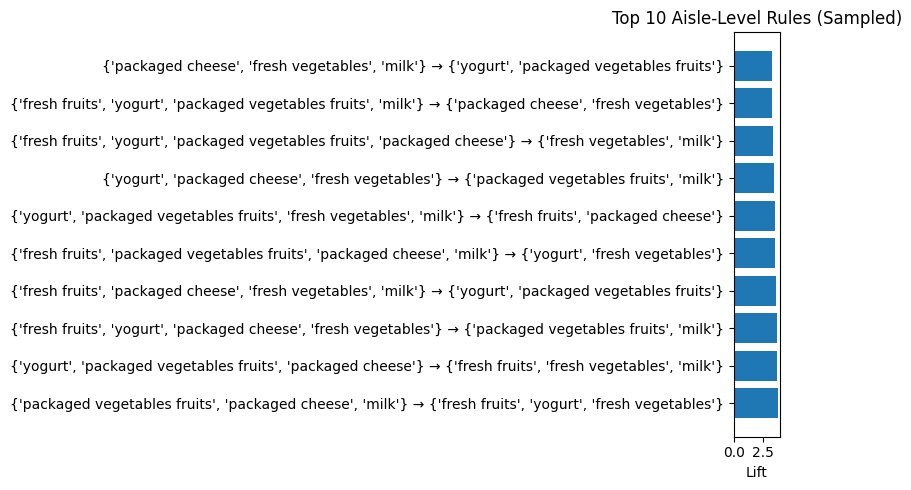

In [7]:
labels = [f"{set(a)} → {set(c)}" for a,c in zip(top_10_aisle.antecedents, top_10_aisle.consequents)]
plt.figure(figsize=(8,5))
plt.barh(labels, top_10_aisle.lift)
plt.xlabel('Lift')
plt.title('Top 10 Aisle-Level Rules (Sampled)')
plt.tight_layout()
plt.show()


In [8]:
# Export the top 10 rules
top_10_aisle.to_csv('top_10_aisle_rules.csv', index=False)

# (Optional) Export the full rule set for further exploration
aisle_rules.to_csv('all_aisle_rules.csv', index=False)


In [9]:
import pandas as pd, os

print("Current working dir:", os.getcwd())
files = os.listdir('.')
print("\nFiles in folder (top-level):", files)

# Try reading the two small files we use for dashboards
for fname in ['top_10_aisle_rules.csv', 'all_aisle_rules.csv']:
    try:
        df = pd.read_csv(fname)
        print(f"\n{fname}: OK — shape = {df.shape}")
        display(df.head(3))
    except FileNotFoundError:
        print(f"\n{fname}: NOT FOUND")
    except Exception as e:
        print(f"\n{fname}: ERROR reading ({e})")


Current working dir: c:\Users\kalya\OneDrive\Documents\Market-Basket

Files in folder (top-level): ['.git', '.gitignore', '.ipynb_checkpoints', '01_Notebook.ipynb', 'all_aisle_rules.csv', 'Dataset', 'LICENSE.txt', 'README.md', 'requirements.txt', 'top_10_aisle_rules.csv', 'venv']

top_10_aisle_rules.csv: OK — shape = (10, 5)


,antecedents,consequents,support,confidence,lift
0,"frozenset({'packaged vegetables fruits', 'pack...","frozenset({'fresh fruits', 'yogurt', 'fresh ve...",0.01065,0.337239,3.714492
1,"frozenset({'yogurt', 'packaged vegetables frui...","frozenset({'fresh fruits', 'fresh vegetables',...",0.01065,0.340473,3.645323
2,"frozenset({'fresh fruits', 'yogurt', 'packaged...","frozenset({'packaged vegetables fruits', 'milk'})",0.01065,0.337452,3.626182



all_aisle_rules.csv: OK — shape = (1856, 14)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,frozenset({'baby food formula'}),frozenset({'fresh fruits'}),0.01924,0.57912,0.01473,0.765593,1.321993,1.0,0.003588,1.795506,0.248344,0.025239,0.443054,0.395514
1,frozenset({'baby food formula'}),frozenset({'fresh vegetables'}),0.01924,0.44933,0.01073,0.557692,1.241164,1.0,0.002085,1.244993,0.198117,0.023436,0.196783,0.290786
2,frozenset({'baking ingredients'}),frozenset({'fresh fruits'}),0.03265,0.57912,0.02074,0.635222,1.096875,1.0,0.001832,1.153798,0.091300,0.035091,0.133297,0.335518


In [10]:
# Run this in 01_Notebook.ipynb (new cell)
import pandas as pd
import re

def extract_inside_frozenset(s):
    s = str(s)
    # find inner text inside frozenset({...})
    m = re.search(r"frozenset\(\{(.*)\}\)", s)
    if m:
        inner = m.group(1)
    else:
        # if not matching, try to strip surrounding brackets/parens
        inner = re.sub(r"^[\[\(\{]+|[\]\)\}]+$", "", s)
    # remove single quotes and extra whitespace
    inner = inner.replace("'", "").strip()
    return inner

for fname in ['top_10_aisle_rules.csv', 'all_aisle_rules.csv']:
    print(f"\nProcessing {fname} ...")
    df = pd.read_csv(fname)
    # make sure antecedents/consequents exist
    if 'antecedents' in df.columns and 'consequents' in df.columns:
        df['Clean antecedents'] = df['antecedents'].apply(extract_inside_frozenset)
        df['Clean consequents'] = df['consequents'].apply(extract_inside_frozenset)
        df['Clean Rule'] = df['Clean antecedents'] + " → " + df['Clean consequents']
    else:
        print(f"  WARNING: {fname} missing antecedents/consequents columns; skipping Clean Rule")
    # save back (overwrite)
    df.to_csv(fname, index=False)
    print(f"  Saved {fname} (shape {df.shape}). Here are first 3 rows:")
    display(df.head(3))



Processing top_10_aisle_rules.csv ...
  Saved top_10_aisle_rules.csv (shape (10, 8)). Here are first 3 rows:


,antecedents,consequents,support,confidence,lift,Clean antecedents,Clean consequents,Clean Rule
0,"frozenset({'packaged vegetables fruits', 'pack...","frozenset({'fresh fruits', 'yogurt', 'fresh ve...",0.01065,0.337239,3.714492,"packaged vegetables fruits, packaged cheese, milk","fresh fruits, yogurt, fresh vegetables","packaged vegetables fruits, packaged cheese, m..."
1,"frozenset({'yogurt', 'packaged vegetables frui...","frozenset({'fresh fruits', 'fresh vegetables',...",0.01065,0.340473,3.645323,"yogurt, packaged vegetables fruits, packaged c...","fresh fruits, fresh vegetables, milk","yogurt, packaged vegetables fruits, packaged c..."
2,"frozenset({'fresh fruits', 'yogurt', 'packaged...","frozenset({'packaged vegetables fruits', 'milk'})",0.01065,0.337452,3.626182,"fresh fruits, yogurt, packaged cheese, fresh v...","packaged vegetables fruits, milk","fresh fruits, yogurt, packaged cheese, fresh v..."



Processing all_aisle_rules.csv ...
  Saved all_aisle_rules.csv (shape (1856, 17)). Here are first 3 rows:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski,Clean antecedents,Clean consequents,Clean Rule
0,frozenset({'baby food formula'}),frozenset({'fresh fruits'}),0.01924,0.57912,0.01473,0.765593,1.321993,1.0,0.003588,1.795506,0.248344,0.025239,0.443054,0.395514,baby food formula,fresh fruits,baby food formula → fresh fruits
1,frozenset({'baby food formula'}),frozenset({'fresh vegetables'}),0.01924,0.44933,0.01073,0.557692,1.241164,1.0,0.002085,1.244993,0.198117,0.023436,0.196783,0.290786,baby food formula,fresh vegetables,baby food formula → fresh vegetables
2,frozenset({'baking ingredients'}),frozenset({'fresh fruits'}),0.03265,0.57912,0.02074,0.635222,1.096875,1.0,0.001832,1.153798,0.091300,0.035091,0.133297,0.335518,baking ingredients,fresh fruits,baking ingredients → fresh fruits
